


Epoch 1/20


108450/108450 [==============================] - 268s 2ms/step - loss: 0.5594 - accuracy: 0.7420 - val_loss: 0.5566 - val_accuracy: 0.7426 - lr: 0.0010
Epoch 2/20
108450/108450 [==============================] - 287s 3ms/step - loss: 0.5584 - accuracy: 0.7424 - val_loss: 0.5557 - val_accuracy: 0.7425 - lr: 0.0010
Epoch 3/20
108450/108450 [==============================] - 282s 3ms/step - loss: 0.5584 - accuracy: 0.7423 - val_loss: 0.5557 - val_accuracy: 0.7426 - lr: 0.0010
Epoch 4/20
108450/108450 [==============================] - 267s 2ms/step - loss: 0.5585 - accuracy: 0.7424 - val_loss: 0.5559 - val_accuracy: 0.7426 - lr: 0.0010
Epoch 5/20
108450/108450 [==============================] - 269s 2ms/step - loss: 0.5581 - accuracy: 0.7424 - val_loss: 0.5555 - val_accuracy: 0.7427 - lr: 5.0000e-04
Epoch 6/20
108450/108450 [==============================] - 368s 3ms/step - loss: 0.5582 - accuracy: 0.7424 - val_loss: 0.5558 - val_accuracy: 0.7428 - lr: 5.0000e-04
Epoch 7/2

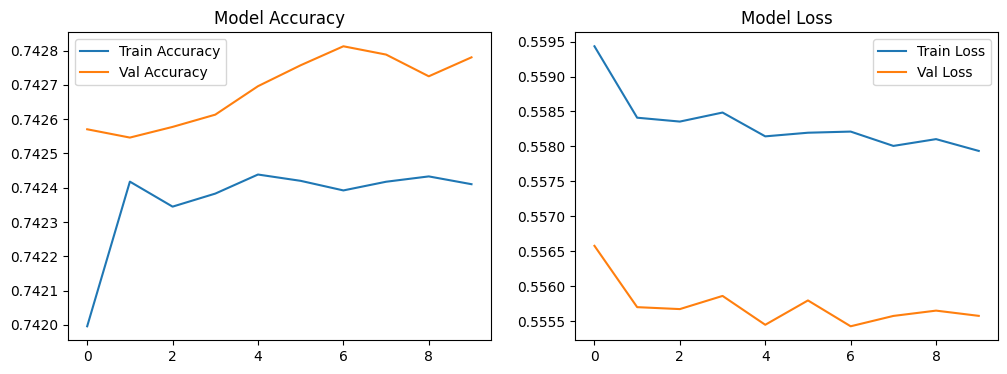

In [1]:
import os
import pyedflib
import pandas as pd
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, BatchNormalization, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def load_edf_files(folder_path):
    data = {'rest': [], 'task': []}
    files = os.listdir(folder_path)
    for file_name in files:
        if file_name.endswith('.edf'):
            file_path = os.path.join(folder_path, file_name)
            try:
                f = pyedflib.EdfReader(file_path)
                signals = {}
                for i in range(f.signals_in_file):
                    signals[f.getLabel(i)] = f.readSignal(i)
                f.close()
                if file_name.endswith('_1.edf'):
                    data['rest'].append(pd.DataFrame(signals))
                elif file_name.endswith('_2.edf'):
                    data['task'].append(pd.DataFrame(signals))
                else:
                    print(f"Unknown file format: {file_name}")
            except Exception as e:
                print(f"Error reading {file_name}: {e}")
    return data

folder_path = "C:\\Users\\visha\\Downloads\\eeg-during-mental-arithmetic-tasks-1.0.0\\eeg-during-mental-arithmetic-tasks-1.0.0"
loaded_data = load_edf_files(folder_path)
rest_data = pd.concat(loaded_data['rest'], ignore_index=True) if loaded_data['rest'] else None
task_data = pd.concat(loaded_data['task'], ignore_index=True) if loaded_data['task'] else None

bands = {'Delta': (1, 4), 'Theta': (4, 8), 'Alpha': (8, 12), 'Beta': (12, 30), 'Gamma': (30, 100)}
sf = 256

def band_power(data, sf, band):
    freqs, psd = welch(data, sf, nperseg=min(sf*2, len(data)))
    band_power = np.trapz(psd[(freqs >= band[0]) & (freqs <= band[1])], freqs[(freqs >= band[0]) & (freqs <= band[1])])
    return band_power

rest_data_array = rest_data.to_numpy()
task_data_array = task_data.to_numpy()

def compute_band_powers(data_array):
    band_powers = {band: [] for band in bands}
    for band in bands:
        band_power_list = []
        for channel_data in data_array.T:
            band_power_list.append(band_power(channel_data, sf, bands[band]))
        band_powers[band] = np.array(band_power_list)
    return band_powers

band_powers_rest = compute_band_powers(rest_data_array)
band_powers_task = compute_band_powers(task_data_array)

features_rest = pd.DataFrame(rest_data_array)
features_task = pd.DataFrame(task_data_array)
features_rest['Label'] = 0
features_task['Label'] = 1
features_all = pd.concat([features_rest, features_task], ignore_index=True)

X = features_all.iloc[:, :-1].values
y = features_all['Label'].values
X = X.reshape((X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Preparation and Training
def build_eegnet_model(input_shape):
    model = Sequential([
        Conv2D(16, (1, 10), input_shape=input_shape, padding='same', activation='relu'),
        BatchNormalization(),
        DepthwiseConv2D((2, 1), padding='same', activation='relu'),
        BatchNormalization(),
        AveragePooling2D(pool_size=(2, 1)),  # Adjusted pool size to (2, 1)
        Dropout(0.5),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return model

X_train_reshape = X_train.reshape((-1, X_train.shape[1], 1, 1))
X_test_reshape = X_test.reshape((-1, X_test.shape[1], 1, 1))

eegnet_model = build_eegnet_model(input_shape=X_train_reshape.shape[1:])
eegnet_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

history = eegnet_model.fit(X_train_reshape, y_train, epochs=20, batch_size=32, validation_data=(X_test_reshape, y_test), verbose=1, callbacks=[early_stopping, reduce_lr])

loss, accuracy = eegnet_model.evaluate(X_test_reshape, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Model Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Model Loss')
    plt.show()

plot_history(history)


Epoch 1/10
2107/2107 [==============================] - 85s 38ms/step - loss: 0.6373 - accuracy: 0.6461 - val_loss: 0.6066 - val_accuracy: 0.6745 - lr: 0.0010
Epoch 2/10
2107/2107 [==============================] - 80s 38ms/step - loss: 0.6018 - accuracy: 0.6840 - val_loss: 0.5627 - val_accuracy: 0.7125 - lr: 0.0010
Epoch 3/10
2107/2107 [==============================] - 77s 36ms/step - loss: 0.5658 - accuracy: 0.7142 - val_loss: 0.5290 - val_accuracy: 0.7353 - lr: 0.0010
Epoch 4/10
2107/2107 [==============================] - 80s 38ms/step - loss: 0.5461 - accuracy: 0.7288 - val_loss: 0.5225 - val_accuracy: 0.7361 - lr: 0.0010
Epoch 5/10
2107/2107 [==============================] - 77s 36ms/step - loss: 0.5290 - accuracy: 0.7410 - val_loss: 0.4887 - val_accuracy: 0.7607 - lr: 0.0010
Epoch 6/10
2107/2107 [==============================] - 81s 38ms/step - loss: 0.5156 - accuracy: 0.7506 - val_loss: 0.4743 - val_accuracy: 0.7720 - lr: 0.0010
Epoch 7/10
2107/2107 [========================

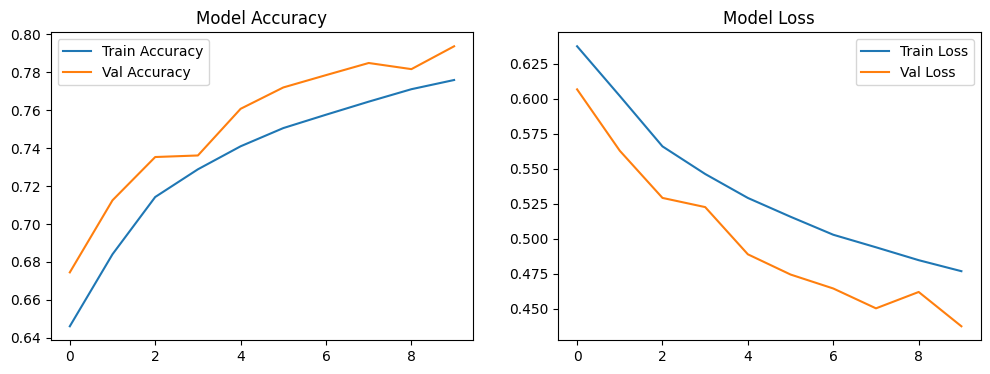

In [3]:
import os
import pyedflib
import pandas as pd
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, BatchNormalization, AveragePooling2D, Flatten, Dense, Dropout, LSTM, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Sample a subset of the data for quick testing
def load_edf_files(folder_path, sample_fraction=0.1):
    data = {'rest': [], 'task': []}
    files = [f for f in os.listdir(folder_path) if f.endswith('.edf')]
    sample_files = np.random.choice(files, int(len(files) * sample_fraction), replace=False)
    for file_name in sample_files:
        file_path = os.path.join(folder_path, file_name)
        try:
            f = pyedflib.EdfReader(file_path)
            signals = {f.getLabel(i): f.readSignal(i) for i in range(f.signals_in_file)}
            f.close()
            if file_name.endswith('_1.edf'):
                data['rest'].append(pd.DataFrame(signals))
            elif file_name.endswith('_2.edf'):
                data['task'].append(pd.DataFrame(signals))
        except Exception as e:
            print(f"Error reading {file_name}: {e}")
    return data

folder_path = "C:\\Users\\visha\\Downloads\\eeg-during-mental-arithmetic-tasks-1.0.0\\eeg-during-mental-arithmetic-tasks-1.0.0"
loaded_data = load_edf_files(folder_path)
rest_data = pd.concat(loaded_data['rest'], ignore_index=True) if loaded_data['rest'] else None
task_data = pd.concat(loaded_data['task'], ignore_index=True) if loaded_data['task'] else None

bands = {'Delta': (1, 4), 'Theta': (4, 8), 'Alpha': (8, 12), 'Beta': (12, 30), 'Gamma': (30, 100)}
sf = 256

def band_power(data, sf, band):
    freqs, psd = welch(data, sf, nperseg=min(sf*2, len(data)))
    band_power = np.trapz(psd[(freqs >= band[0]) & (freqs <= band[1])], freqs[(freqs >= band[0]) & (freqs <= band[1])])
    return band_power

rest_data_array = rest_data.to_numpy()
task_data_array = task_data.to_numpy()

def compute_band_powers(data_array):
    band_powers = {band: [] for band in bands}
    for band in bands:
        band_power_list = [band_power(channel_data, sf, bands[band]) for channel_data in data_array.T]
        band_powers[band] = np.array(band_power_list)
    return band_powers

band_powers_rest = compute_band_powers(rest_data_array)
band_powers_task = compute_band_powers(task_data_array)

features_rest = pd.DataFrame(rest_data_array)
features_task = pd.DataFrame(task_data_array)
features_rest['Label'] = 0
features_task['Label'] = 1
features_all = pd.concat([features_rest, features_task], ignore_index=True)

X = features_all.iloc[:, :-1].values
y = features_all['Label'].values
X = X.reshape((X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Preparation and Training
def build_cnn_lstm_model(input_shape):
    model = Sequential([
        Conv2D(16, (1, 3), input_shape=input_shape, padding='same', activation='relu'),
        BatchNormalization(),
        DepthwiseConv2D((1, 3), padding='same', activation='relu'),
        BatchNormalization(),
        AveragePooling2D(pool_size=(1, 1)),
        Dropout(0.3),
        
        Conv2D(32, (1, 3), padding='same', activation='relu'),
        BatchNormalization(),
        DepthwiseConv2D((1, 3), padding='same', activation='relu'),
        BatchNormalization(),
        AveragePooling2D(pool_size=(1, 1)),
        Dropout(0.3),
        
        Reshape((input_shape[0], -1)),
        LSTM(32, return_sequences=True),
        LSTM(32),
        Dropout(0.5),
        
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

X_train_reshape = X_train.reshape((-1, X_train.shape[1], 1, 1))
X_test_reshape = X_test.reshape((-1, X_test.shape[1], 1, 1))

cnn_lstm_model = build_cnn_lstm_model(input_shape=X_train_reshape.shape[1:])
cnn_lstm_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

history = cnn_lstm_model.fit(X_train_reshape, y_train, epochs=10, batch_size=128, validation_data=(X_test_reshape, y_test), verbose=1, callbacks=[early_stopping, reduce_lr])

loss, accuracy = cnn_lstm_model.evaluate(X_test_reshape, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Model Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Model Loss')
    plt.show()

plot_history(history)
  
